In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import gc
import myutil

#ref: https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code#L294

In [2]:
class lgbWrapper():
    def __init__(self, seed=0, params=None):
        return
    
    def init_model(self):
        self.clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        return    

    def train(self, trn_x, trn_y):
        self.clf.fit(trn_x, trn_y, verbose=100)

    def predict(self, x):
        result = self.clf.predict_proba(x, num_iteration=self.clf.best_iteration_)[:, 1]
        return result
    
    def get_coef(self):
        return self.clf.feature_importances_

lgb = lgbWrapper()

In [3]:
data, test, y = myutil.get_train_test_label()


(307511, 826)
(48744, 826)


In [4]:
oof_preds, test_preds, importances, folds = myutil.cross_validation(data, test, y, lgb)

Fold  1 AUC : 0.785396
Fold  2 AUC : 0.782126
Fold  3 AUC : 0.783657
Fold  4 AUC : 0.784734
Fold  5 AUC : 0.780090
Full AUC score 0.783181


lightgbm
Index(['DAYS_BIRTH', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'AMT_CREDIT',
       'EXT_SOURCE_1', 'REGION_POPULATION_RELATIVE', 'bureau_DAYS_CREDIT_max',
       'DAYS_LAST_PHONE_CHANGE', 'bureau_DAYS_CREDIT_ENDDATE_max',
       'prev_app_HOUR_APPR_PROCESS_START_mean', 'AMT_GOODS_PRICE',
       'bureau_DAYS_ENDDATE_FACT_max',
       'prev_app_DAYS_LAST_DUE_1ST_VERSION_max', 'AMT_INCOME_TOTAL',
       'prev_app_AMT_CREDIT_APPLICATION_RATIO_max',
       'bureau_AMT_CREDIT_SUM_min', 'install_AMT_PAYMENT_min',
       'bureau_DAYS_CREDIT_UPDATE_max', 'install_DAYS_ENTRY_PAYMENT_max',
       'prev_app_DAYS_FIRST_DUE_max', 'install_AMT_INSTALMENT_min',
       'prev_app_DAYS_DECISION_max', 'bureau_AMT_CREDIT_SUM_mean',
       'prev_app_AMT_ANNUITY_min',
       'prev_app_AMT_CREDIT_APPLICATION_RATIO_mean',
       'install_DAYS_LATE_PAYMENT_mean', 'prev_app_AMT_GOODS_PRICE_min',
       'install_AMT_PAYMENT_INSTALMENT_

/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


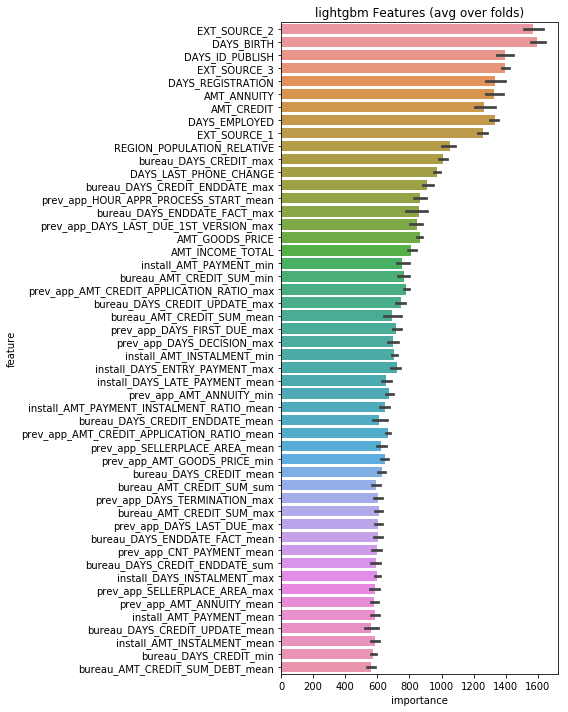

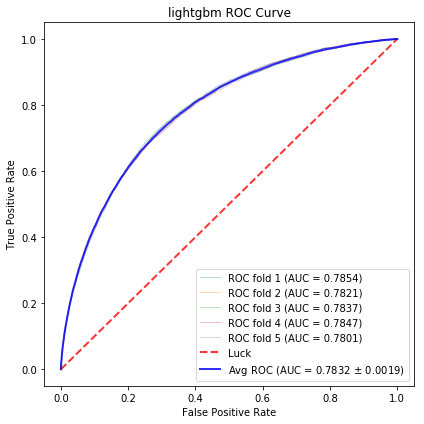

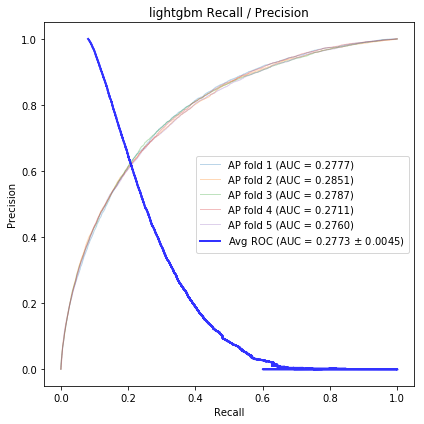

In [5]:
title = 'lightgbm'
myutil.report(test_preds, folds, importances, data, y, oof_preds, title)